In [1]:

import numpy as np

import matplotlib.pyplot as plt

import gpflow

from scipy.stats import norm

from gpflow.functions import Constant

from rcgp_batch.rcgp.rcgp import RCGPR
from rcgp_batch.rcgp.w import IMQ

plt.rc('font', family='serif', size=16)
plt.rcParams['text.usetex'] = True

In [2]:
def generate_data(lengthscale, variance_kernel, var_y, n, seed=0):
    np.random.seed(seed)
    kernel = gpflow.kernels.SquaredExponential(variance=variance_kernel, lengthscales=lengthscale)
    X = np.linspace(-5, 5, n)[:, None]  # 100 points in [-5, 5]

    # Compute the covariance matrix using the kernel
    K = kernel(X).numpy()  # Kernel matrix

    # Add a small jitter for numerical stability
    jitter = 1e-6
    K += jitter * np.eye(len(X))

    # Generate samples from the Gaussian Process
    mean = np.zeros(len(X))  # Mean function (zero mean)
    mean_func = np.random.multivariate_normal(mean, K, size=1).flatten()  # 3 sample paths

    y = mean_func +  np.random.normal(0, np.sqrt(var_y), size=len(X))

    return X.flatten(), y.flatten(), mean_func

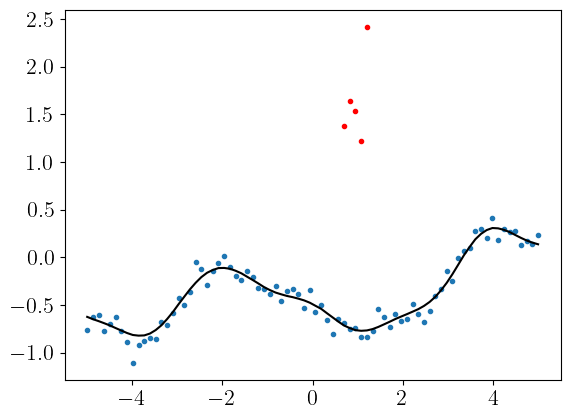

In [3]:
obs_grid, obs, mean_func = generate_data(lengthscale=1.,
                                         variance_kernel=0.2,
                                         var_y=0.01,
                                         n=80,
                                         seed=3)

obs_outliers = obs.copy()
outliers_idx = [45, 46, 47, 48, 49]
obs_outliers[outliers_idx] = np.random.normal(obs.mean()+2, 0.3, len(outliers_idx))

plt.plot(obs_grid, obs, '.')
plt.plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', color='red')
plt.plot(obs_grid, mean_func, color='black')

In [4]:
c = np.quantile(np.abs(obs - Constant(obs.mean())(obs_grid.reshape(-1,1))), 1 - len(outliers_idx)/len(obs)) 

#Train on outliers
model = RCGPR(
    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=Constant(obs.mean()),
    noise_variance=0.001
)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
gpflow.set_trainable(model.weighting_function.C, False)
gpflow.set_trainable(model.mean_function.c, False)

res1 = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)

f_mean_dsm_const, f_var_dsm_const = model.predict_f(obs_grid.reshape(-1,1), full_cov=False)

f_std_dsm_const = np.sqrt(f_var_dsm_const).flatten()

#Train on no outliers
model_no = RCGPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=Constant(obs.mean()),
    noise_variance=0.001
)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
gpflow.set_trainable(model_no.weighting_function.C, False)
gpflow.set_trainable(model_no.mean_function.c, False)

res2 = opt.minimize(model_no.training_loss_closure(), model_no.trainable_variables, options=opt_options)

f_mean_dsm_const_no, f_var_dsm_const_no = model_no.predict_f(obs_grid.reshape(-1,1), full_cov=False)

f_std_dsm_const_no = np.sqrt(f_var_dsm_const_no).flatten()

In [5]:
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
RCGPR.mean_function.c,Parameter,Identity,,False,(),float64,-0.385156
RCGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.991997
RCGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.186126
RCGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0255218
RCGPR.weighting_function.C,Parameter,Softplus,,False,(),float64,0.658936


In [6]:
gpflow.utilities.print_summary(model_no, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
RCGPR.mean_function.c,Parameter,Identity,,False,(),float64,-0.385156
RCGPR.kernel.variance,Parameter,Softplus,,True,(),float64,36.9351
RCGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.45536
RCGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00658729
RCGPR.weighting_function.C,Parameter,Softplus,,False,(),float64,0.658936


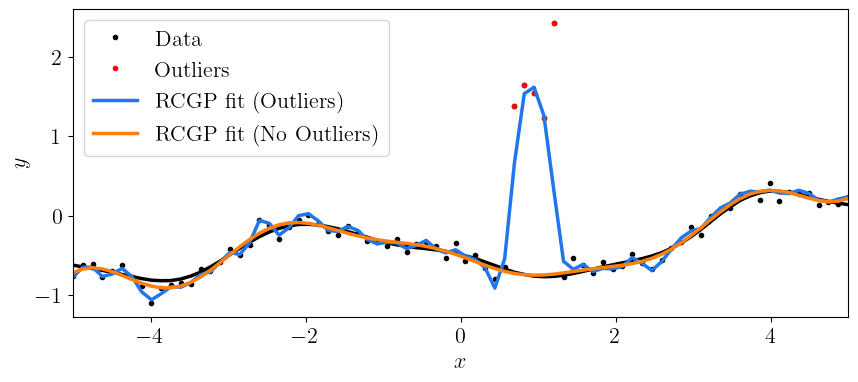

In [7]:
color1 = "#1f77e9"
color2 = "#ff7f0e"

plt.rcParams['lines.linewidth'] = 2.5

plt.figure(figsize=(10,4))
plt.plot(obs_grid, obs_outliers, '.', color='black', label="Data")
plt.plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', color='red', label="Outliers")
plt.plot(obs_grid, mean_func, '-', color='black')

plt.plot(obs_grid, f_mean_dsm_const, '-', color=color1, label="RCGP fit (Outliers)")
plt.plot(obs_grid, f_mean_dsm_const_no, '-', color=color2, label="RCGP fit (No Outliers)")

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.xlim(obs_grid[0], obs_grid[-1])
plt.legend(fontsize=16)

plt.savefig("./rcgp-param-optim-issue.pdf", format='pdf', bbox_inches='tight')